In [15]:
import pandas as pd
import itertools
import hashlib
from tqdm import tqdm
from collections import defaultdict
from multiprocessing import Pool


In [16]:
df = pd.read_csv('../files/atchley.csv')
df.set_index('amino.acid', inplace=True)
atchley_features = df.to_dict(orient='index')
for key, value in atchley_features.items():
    atchley_features[key] = list(value.values())

In [17]:
# def hash_sequences(mutations_lst, hash_method):
#     new_lst = []
#     for row in tqdm(mutations_lst, desc="hashing sequences"):
#         hash_value = hash_method(row[0])
#         new_lst.append([row[0], hash_value, row[2]])
#     return new_lst


def hash_sequences(mutations_lst, hash_method, atchley_features):
    return [[row[0], hash_method(row[0], atchley_features), row[2]] for row in tqdm(mutations_lst, desc="hashing sequences")]


In [18]:
def hash_atchley_sha_int(sequence, atchley_features):
    hash_input = ''.join(''.join(map(str, atchley_features.get(aa))) for aa in sequence)
    hash_object = hashlib.md5(hash_input.encode())
    hash_number = int.from_bytes(hash_object.digest(), byteorder='big')
    return hash_number


In [19]:
def generate_mutations(sequence, max_mutations):
    yield sequence, 0, ""
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    for i in range(1, max_mutations + 1):
        for positions in itertools.combinations(range(len(sequence)), i):
            for new_aas in itertools.product(aa, repeat=i):
                mutated_sequence = list(sequence)
                for pos, new_aa in zip(positions, new_aas):
                    mutated_sequence[pos] = new_aa
                mutated_sequence = "".join(mutated_sequence)
                if mutated_sequence != sequence:
                    yield mutated_sequence, 0, sequence


In [20]:
def truncate_sequences(sequences, right, left):
    middle_strings = []
    for sequence in tqdm(sequences, "truncating sequences"):
        start_index = max(0, len(sequence)//2 - left)
        end_index = min(len(sequence)//2 + right, len(sequence))
        middle_strings.append(sequence[start_index:end_index])
    return middle_strings

In [21]:
sequence_map = {}

# 1000 sequences
sequences_csv = '../files/forchen_F_26L.csv'
sequences_header = "cdr3_amino_acid"

# # 40K sequences
# sequences_csv = '../files/for_chen_B.csv'
# sequences_header = "CDR3.aa"

# # 1M sequences
# sequences_csv = "../random_sequences.csv"
# sequences_header = "sequences"

mutations_df = pd.DataFrame(columns=['mutation','mutation_hash' 'original'])

sequences_df = pd.read_csv(sequences_csv)
sequences_set = set(sequences_df[sequences_header].unique())
# sequences_hashed = hash_sequences(sequences_set, hash_atchley_sha_int,sequence_map)



In [22]:
sequences_set = truncate_sequences(sequences_set, 4, 4)

truncating sequences: 100%|██████████| 1178/1178 [00:00<00:00, 645952.43it/s]


In [23]:
max_mutations = 1

mutations_lst = []

for seq in tqdm(sequences_set, desc="generating mutations"):
    mutations_lst.extend(generate_mutations(seq, max_mutations))

generating mutations: 100%|██████████| 1178/1178 [00:00<00:00, 5828.36it/s]


In [24]:
mutations_lst = hash_sequences(mutations_lst, hash_atchley_sha_int)

hashing sequences: 100%|██████████| 180234/180234 [00:03<00:00, 56068.84it/s]


In [25]:
mutations_df = pd.DataFrame(mutations_lst, columns=['mut', 'mut_hash', 'org'])
mutations_sorted = mutations_df.sort_values(by='mut_hash')

In [26]:
distances_csv = "../distance_matrix.csv"
distances_df = pd.read_csv(distances_csv, index_col=0)
distances_dict = {(aa1, aa2): distances_df.loc[aa1, aa2] for aa1 in distances_df.index for aa2 in distances_df.columns}

In [27]:
couples = defaultdict(list)
mask_org_empty = mutations_sorted['org'] == ""
duplicates_with_empty_org = mutations_sorted[mutations_sorted.duplicated(['mut_hash'], keep=False) & mask_org_empty]
filtered_df = mutations_sorted[mutations_sorted['mut_hash'].isin(duplicates_with_empty_org['mut_hash'])]

In [28]:

for index, row in tqdm(list(filtered_df.iterrows()), "finding duplicates"):
    if row["org"] != "":
        mut = row["mut"]
        seq = row["org"]
        couples[seq].append([mut, sum(distances_dict[(aa1, aa2)] for aa1, aa2 in zip(seq, mut))])


finding duplicates: 100%|██████████| 80/80 [00:00<00:00, 10511.71it/s]


In [29]:
couples = {key: sorted(value, key=lambda x: x[1]) for key, value in couples.items()}

In [30]:
# import json

# with open("../couples.json") as json_file:
#     couples = json.load(json_file)


In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

max_neig = 1
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the dictionary
for node, neighbors in couples.items():
    count = 0
    for neighbor, weight in neighbors:
        if count < max_neig:
            G.add_edge(node, neighbor, weight=weight)
            count += 1

In [32]:
def get_edges_colors(G):
    # color edegs according to their connection, the greener the color the stringer the connection
    # Create a colormap ranging from red to green
    cmap = plt.cm.RdYlGn_r

    # Find the maximum and minimum weights
    max_weight = max([d['weight'] for _, _, d in G.edges(data=True)])
    min_weight = min([d['weight'] for _, _, d in G.edges(data=True)])

    # Normalize the weights
    norm = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    # Create a color mapping based on edge weights
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in G.edges(data=True)]
    return edge_colors
    

### Visualize the whole graph

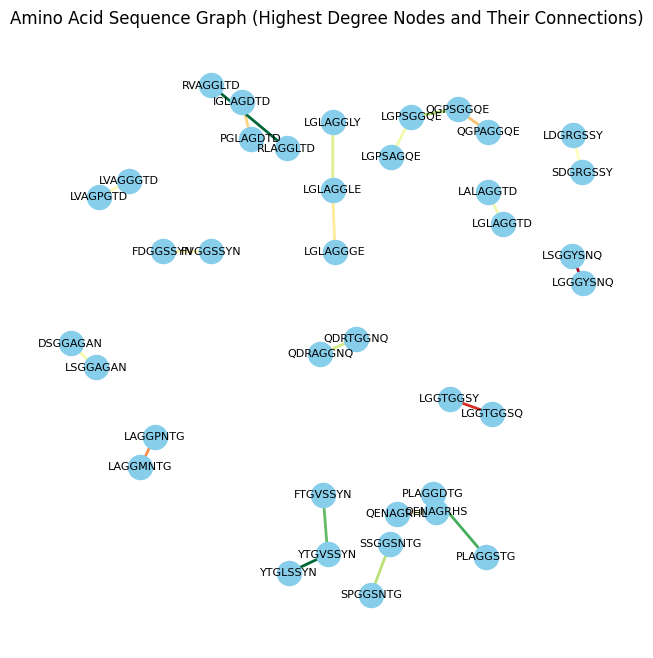

In [33]:

edge_colors = get_edges_colors(G)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.3, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('trunc seq whole graph.png')
plt.show()

### Highest degree node

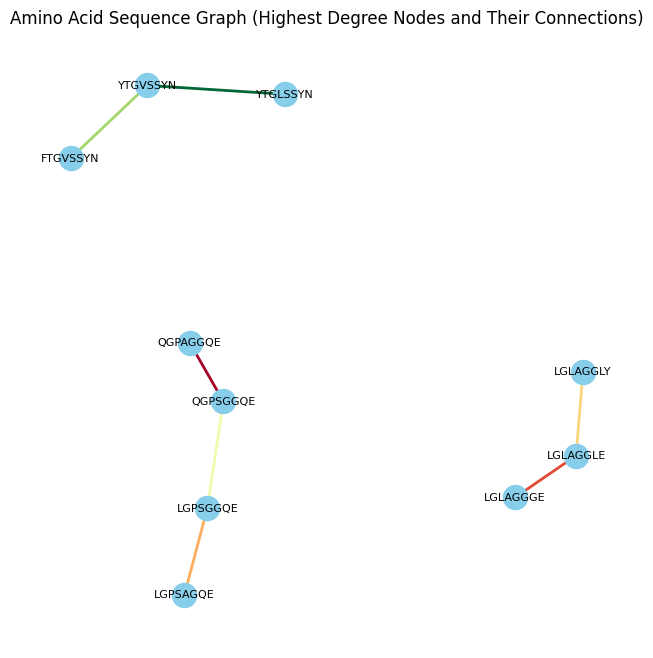

In [34]:
max_degree = max(dict(G.degree()).values())
highest_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == max_degree]

# Create a subgraph with only the highest degree nodes and their neighbors
highest_degree_neighbors = set()
for node in highest_degree_nodes:
    highest_degree_neighbors.update(G.neighbors(node))
highest_degree_neighbors.update(highest_degree_nodes)
H = G.subgraph(highest_degree_neighbors)

edge_colors = get_edges_colors(H)

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('trunc seq highest degree.png')
plt.show()


### Longest path

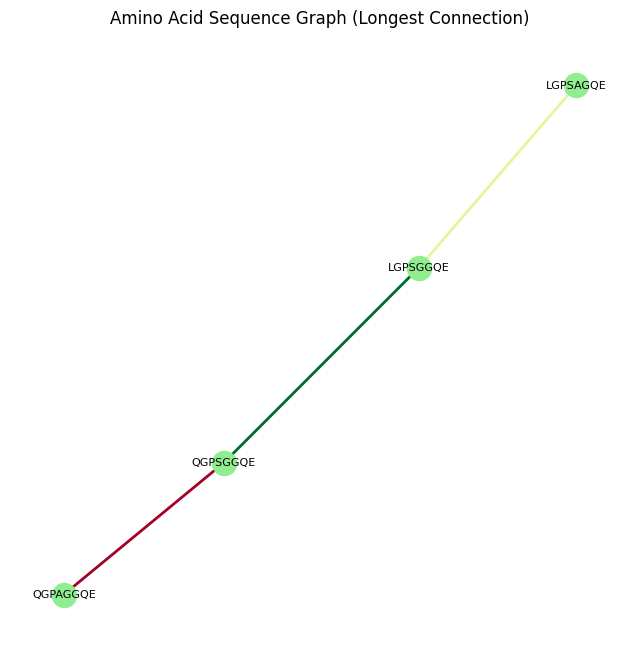

In [35]:
# Find the longest path in the graph
longest_path = max(nx.all_pairs_shortest_path_length(G), key=lambda x: max(x[1].values()))

# Extract nodes involved in the longest path
longest_path_nodes = longest_path[1].keys()

# Create a subgraph with nodes involved in the longest path
H = G.subgraph(longest_path_nodes)

edge_colors = get_edges_colors(H)


# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Longest Connection)')
plt.axis('off')  # Turn off axis
plt.savefig('trunc seq longest path.png')
plt.show()